In [1]:
import os
import sys
sys.path.insert(0, '/home/jovyan/braindecode/')
sys.path.insert(0, '/home/jovyan/mne-python/')
import re

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_color_codes('deep')
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from braindecode.datasets import TUHAbnormal

<ipython-input-1-9da090ffb2f1>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
data_path = '/home/jovyan/mne_data/TUH/tuh_eeg_abnormal/v2.0.0/edf/'
n_jobs = 4

In [3]:
tuabn_train = TUHAbnormal(
    path=data_path,
    preload=False,
    add_physician_reports=True,
    n_jobs=n_jobs,
    target_name='age',
)

In [4]:
tuabn_train.description.pathological.value_counts()

False    1521
True     1472
Name: pathological, dtype: int64

In [5]:
TUHAbnormal._read_edf_header(tuabn_train.description[tuabn_train.description.subject == 4196].loc[0, 'path'])

b'0       00004196 F 01-JAN-1956 00004196 Age:53                                          '

In [6]:
for d in tuabn_train.datasets:
    d.description['report'] = TUHAbnormal._read_physician_report(
        d.description.path.replace('TUH_PRE', 'TUH').replace('.edf', '.txt'),
    )

In [9]:
from decode_tueg import add_ages_from_additional_sources

In [11]:
tuabn_train = add_ages_from_additional_sources(tuabn_train)

In [13]:
tuabn_train.description

,path,version,year,month,day,subject,session,segment,train,pathological,report,age,gender,date_age,report_age
0,/home/jovyan/mne_data/TUH/tuh_eeg_abnormal/v2....,v2.0.0,2009,9,3,4196,3,0,False,False,CLINICAL HISTORY: Seizures.\nMEDICATIONS: Dil...,53,F,NaN,NaN
1,/home/jovyan/mne_data/TUH/tuh_eeg_abnormal/v2....,v2.0.0,2009,9,3,5864,1,0,False,False,"CLINICAL HISTORY: Schizophrenia, memory loss.\...",30,M,NaN,NaN
2,/home/jovyan/mne_data/TUH/tuh_eeg_abnormal/v2....,v2.0.0,2009,9,4,929,3,2,True,False,"CLINICAL HISTORY: Epilepsy, currently seizure...",39,F,NaN,38.0
3,/home/jovyan/mne_data/TUH/tuh_eeg_abnormal/v2....,v2.0.0,2009,9,4,5851,1,1,False,False,CLINICAL HISTORY: Sixty-five-year-old woman w...,65,F,NaN,NaN
4,/home/jovyan/mne_data/TUH/tuh_eeg_abnormal/v2....,v2.0.0,2009,9,9,5909,2,0,True,False,CLINICAL HISTORY: 32 year old male with episod...,32,M,NaN,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2988,/home/jovyan/mne_data/TUH/tuh_eeg_abnormal/v2....,v2.0.0,2013,10,7,6881,2,1,True,True,CLINICAL HISTORY: 50-year-old woman with a his...,51,F,NaN,50.0
2989,/home/jovyan/mne_data/TUH/tuh_eeg_abnormal/v2....,v2.0.0,2013,10,7,7757,3,1,True,False,"CLINICAL HISTORY: A 38-year-old woman, with u...",40,F,NaN,38.0
2990,/home/jovyan/mne_data/TUH/tuh_eeg_abnormal/v2....,v2.0.0,2013,10,7,9289,4,1,True,True,CLINICAL HISTORY: A 22-year-old with refractor...,22,M,NaN,22.0
2991,/home/jovyan/mne_data/TUH/tuh_eeg_abnormal/v2....,v2.0.0,2013,10,10,3240,2,1,True,False,CLINICAL HISTORY: A 55-year-old woman with re...,55,F,NaN,55.0


In [12]:
c1 = (tuabn_train.description.age - tuabn_train.description.report_age).abs() < 2
c2 = (tuabn_train.description.age - tuabn_train.description.date_age).abs() < 2
c3 = (tuabn_train.description.date_age - tuabn_train.description.report_age).abs() < 2
ids = tuabn_train.description[c1 & c2 & c3].index.to_list()
tuabn_train_clean = tuabn_train.split([ids])['0']

AssertionError: datasets should not be an empty iterable

In [9]:
tuabn_train_clean.description

,path,version,year,month,day,subject,session,segment,train,pathological,report,age,gender,date_age,report_age
0,/home/jovyan/mne_data/TUH/tuh_eeg_abnormal/v2....,v2.0.0,2009,9,4,929,3,2,True,False,"CLINICAL HISTORY: Epilepsy, currently seizure...",39,F,39,38
1,/home/jovyan/mne_data/TUH/tuh_eeg_abnormal/v2....,v2.0.0,2009,9,9,5909,2,0,True,False,CLINICAL HISTORY: 32 year old male with episod...,32,M,32,32
2,/home/jovyan/mne_data/TUH/tuh_eeg_abnormal/v2....,v2.0.0,2009,9,10,6201,1,0,False,False,CLINICAL HISTORY: 54 year old male with recurr...,54,M,54,54
3,/home/jovyan/mne_data/TUH/tuh_eeg_abnormal/v2....,v2.0.0,2009,9,10,6422,1,0,False,False,\nCLINICAL HISTORY: 49 year old left handed ...,50,M,50,49
4,/home/jovyan/mne_data/TUH/tuh_eeg_abnormal/v2....,v2.0.0,2009,9,11,5928,1,0,True,True,CLINICAL HISTORY: 71 year old woman with recu...,70,F,70,71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2713,/home/jovyan/mne_data/TUH/tuh_eeg_abnormal/v2....,v2.0.0,2013,10,7,6091,4,0,False,True,"CLINICAL 40-year-old man With LD, Childhood TB...",40,M,40,40
2714,/home/jovyan/mne_data/TUH/tuh_eeg_abnormal/v2....,v2.0.0,2013,10,7,6881,2,1,True,True,CLINICAL HISTORY: 50-year-old woman with a his...,51,F,51,50
2715,/home/jovyan/mne_data/TUH/tuh_eeg_abnormal/v2....,v2.0.0,2013,10,7,9289,4,1,True,True,CLINICAL HISTORY: A 22-year-old with refractor...,22,M,22,22
2716,/home/jovyan/mne_data/TUH/tuh_eeg_abnormal/v2....,v2.0.0,2013,10,10,3240,2,1,True,False,CLINICAL HISTORY: A 55-year-old woman with re...,55,F,55,55


In [6]:
# pattern = r'(\d+)\W[dayer]{3,4}\W[old]{3}'
# pattern = r'(\d+).?[day]+'  # accept day and year
# pattern = r'(\d+).?[dy]+?[ayer]+.?[old]+'
# pattern = r'(\d+)-year-old|(\d+) year old|(\d+) years old|(\d+) day old'
pattern = r'(\d+)[ -]+?[years]{3,5}[ -]+?[old]{3}'

In [44]:
mne_meas_date = {}
birth_years = {}
report_ages = {}
for i in range(len(d)):
    rec_year = tuabn_train.datasets[i].raw.info['meas_date'].year
    mne_meas_date[i] = rec_year

    p = d.loc[i, 'path']
    h = TUHAbnormal._read_edf_header(p)
    matches = re.findall(r'\d{2}-\w{3}-(\d{4})', str(h))
    assert len(matches) == 1
    birth_year = int(matches[0])
    birth_years[i] = birth_year

    r = d.loc[i, 'report']
    matches = re.findall(pattern, r)
    if len(matches) >= 1:
        match = int(matches[0])
    elif len(matches) == 0:
        match = np.nan
    report_ages[i] = match

In [45]:
df = pd.DataFrame([
    {k: mne_meas_date[k]-birth_years[k] for k in mne_meas_date.keys()}, 
    report_ages, 
    d['age'], 
    d['pathological']],
).T

In [46]:
df.columns = ['date_age', 'report_age', 'age', 'pathological']

In [47]:
df[df.report_age.isna()]

,date_age,report_age,age,pathological
0,53,NaN,53,False
1,30,NaN,30,False
3,65,NaN,65,False
93,51,NaN,51,True
117,25,NaN,25,True
...,...,...,...,...
2942,77,NaN,77,True
2958,21,NaN,21,True
2959,21,NaN,21,True
2960,21,NaN,21,True


In [17]:
print(d.loc[2942, 'report'])

CLINICAL HISTORY:  An elderly man with confusion.
MEDICATIONS:  Zithromax, ceftriaxone, hydralazine, aspirin, lisinopril, others.
INTRODUCTION:  Digital video EEG was performed at the bedside using standard 10-20 system of electrode placement with 1 channel EKG.  The patient was agitated and uncooperative.  Electrode impedances were challenging.
DESCRIPTION OF THE RECORD:  The EEG demonstrates a slow and disorganized background.  There are  some sections with a well-defined 7-8 Hz alpha rhythm.  Other sections demonstrate bursts of frontal delta.  There is a significant amount of muscle and movement artifact.  The patient is not always responsive while awake and then demonstrates some inappropriate or involuntary behaviors while awake.
A single left temporal sharp waves was identified.
At the close of the record, the patient drifts off to sleep.  The background EEG demonstrates a more synchronously sleep slow pattern with a heart rate of 90 BPM.
IMPRESSION:  This is a technically chall

In [18]:
df[df.report_age == 13]

,date_age,report_age,age,pathological
779,14,13,14,False


In [19]:
(df.date_age == df.age).sum()

2953

In [20]:
(df.date_age == df.report_age).sum()

1255

In [21]:
(df.age == df.report_age).sum()

1249

In [22]:
df[df.date_age > 100]

,date_age,report_age,age,pathological
137,111,37,37,False
1011,112,81,82,True
1016,112,81,82,True
1169,112,83,83,False
1760,113,42,42,False
1786,113,NaN,0,True
1893,113,68,68,False
2020,113,51,51,False


In [23]:
TUHAbnormal._read_edf_header(d.loc[2020, 'path'])

b'0       00009652 M 01-JAN-1899 00009652 Age:51                                          '

In [24]:
TUHAbnormal._read_edf_header(d.loc[1893, 'path'])

b'0       00009208 F 01-JAN-1899 00009208 Age:68                                          '

In [25]:
TUHAbnormal._read_edf_header(d.loc[1786, 'path'])

b'0       00008982 M 01-JAN-1899 00008982 Age:0.0137                                      '

In [26]:
print(d.loc[1786, 'report'])

CLINICAL HISTORY:  39-week-old gestational age and 37 conceptional age male born to a mother with drug abuse and history of meconium aspiration and low Apgars of 2, 5 and 6 requiring intubation.
MEDICATIONS:  Ativan, Fentanyl, Morphine, Phenobarbital.
REASON FOR STUDY:  Low Apgar scores, abnormal behavior.
INTRODUCTION:  Digital video routine EEG was performed using the standard 10-20 electrode placement system with EMG, EOG and EKG electrodes.  The patient was recorded in quiet sleep as well as awake.  Activating procedures were not performed.
TECHNICAL DIFFICULTIES:  None.
DESCRIPTION OF THE RECORD:  The record opens to an awake mixed frequency moderate to high amplitude activity which is fairly continuous and quiet sleep which displays trace alternatives as pattern.  There is some central as well as temporal delta brushes and some scattered temporal and central sharp waves mainly at C4, T4 and C3.
ABNORMAL FINDINGS:  There are some positive sharp waves seen at T3.
IMPRESSION:  Abnor

In [27]:
TUHAbnormal._read_edf_header(d.loc[1760, 'path'])

b'0       00009054 M 01-JAN-1899 00009054 Age:42                                          '

In [28]:
TUHAbnormal._read_edf_header(d.loc[1169, 'path'])

b'0       00009690 M 01-JAN-1899 00009690 Age:83                                          '

In [29]:
df[df.date_age < 5]

,date_age,report_age,age,pathological
265,0,NaN,0,True
1619,4,24,4,True
1684,1,71,1,True
1727,0,51,52,True
2328,0,72,73,False
2398,3,20,3,False
2768,0,NaN,0,False
2982,1,28,1,False


In [30]:
TUHAbnormal._read_edf_header(d.loc[265, 'path'])

b'0       00007304 F 01-JAN-2010 00007304 Age:0.0192                                      '

In [31]:
print(d.loc[265, 'report'])

CLINICAL HISTORY: 7 day old infant born 37 weeks by history, 35 to 36 weeks by exam to mother with eclampsia. Abnormal MRI of the brain suggesting perinatal anoxia. No report of clinical seizures at this time. The technologist reports that the patient has been doing well but was difficult to arouse during the EEG.

MEDICATIONS: Phenobarbital.

INTRODUCTION: Digital video EEG was performed at bedside with neonatal mentoring using the neonatal montage with the eye monitor. The child is quite sleepy.

DESCRIPTION OF THE RECORD: The background EEG is somewhat slower amplitude than might be anticipated for a neonatal EEG. There are vertex waves observed, delta brushes. There is variability in the record and reactivity. The A1T3 pair demonstrates artifacts. There appears to be some artifact in the left temporal lateral chain. There are a handful of C4 sharp waves as well as O2 sharp waves.

HR: 102 bpm

IMPRESSION: Abnormal EEG for an infant of this age due to:
1. A lower voltage somewhat mo

In [32]:
d.loc[1619, 'path']

'/home/jovyan/mne_data/TUH/tuh_eeg_abnormal/v2.0.0/edf/train/abnormal/01_tcp_ar/088/00008842/s001_2012_05_18/00008842_s001_t000.edf'

In [33]:
TUHAbnormal._read_edf_header(d.loc[1619, 'path'])

b'0       00008842 M 01-JAN-2008 00008842 Age:4                                           '

In [34]:
print(d.loc[1619, 'report'])

CLINICAL HISTORY:  24 year old male with an ATV accident in October, central hematoma, cranioplasty with first generalized seizure in March 2012.
MEDICATIONS:  Keppra.
INTRODUCTION:  Digital video EEG was performed in lab using standard 10-20 system of electrode placement with 1 channel of EKG.  Hyperventilation and photic stimulation are performed.  The patient has a craniotomy defect on the left.
DESCRIPTION OF THE RECORD:  This EEG demonstrates an asymmetry. From the right hemisphere, the EEG is relatively well organized with 10 Hz alpha rhythm. Mu was identified bilaterally. The left hemisphere demonstrates a breech rhythm. In addition, there is theta in the left hemisphere particularly frontocentral and temporal regions. The activity is primarily T3 and C3 as the patient becomes drowsy. Photic stimulation elicits some bilateral driving response. Hyperventilation accentuates the focal theta on the left.
Deeper stages of sleep are not sustained.
HR:    72 bpm
IMPRESSION:  Abnormal E

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from sklearn.metrics import mean_absolute_error

<ipython-input-16-d69288766efc>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [17]:
df = pd.read_csv('/home/lukas/Code/brain_age/ds_descriptions/tuh_abnormal_description_age_sources.csv', index_col=0)

In [18]:
df.date_age.isna().sum()

0

In [19]:
df.report_age.isna().sum()

71

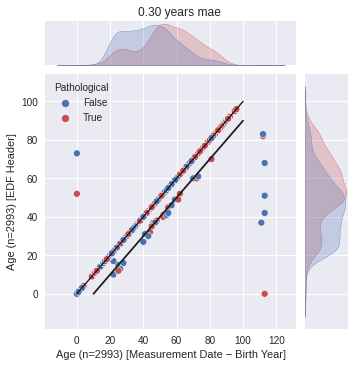

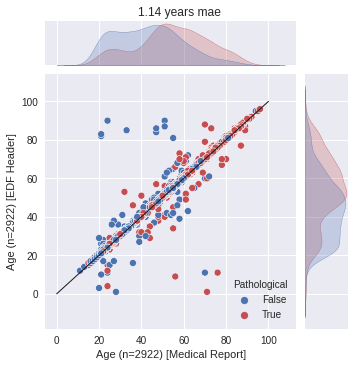

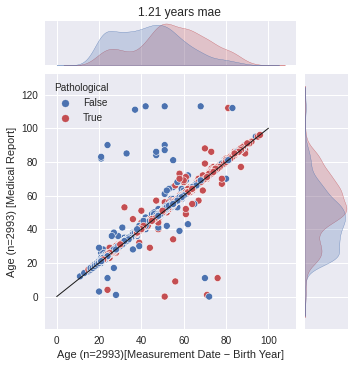

In [31]:
ax = sns.jointplot(data=df, x='date_age', y='age', height=5, hue='pathological', palette=['b', 'r'])
ax.ax_joint.plot([0, 100], [0, 100], c='k', linewidth=1)
ax.ax_joint.set_xlabel(f'Age (n={len(df.date_age)}) [Measurement Date − Birth Year]')
ax.ax_joint.set_ylabel(f'Age (n={len(df.age)}) [EDF Header]')
ax.ax_joint.plot([0, 100], [0, 100], c='k', linewidth=1)
mae = mean_absolute_error(df.date_age, df.age)
ax.ax_joint.get_figure().suptitle(f'{mae:.2f} years mae', y=1.01)
ax.ax_joint.legend(title='Pathological')
ax.ax_joint.plot([10, 100], [0, 90], c='k')

ax = sns.jointplot(data=df, x='report_age', y='age', height=5, hue='pathological', palette=['b', 'r'])
ax.ax_joint.plot([0, 100], [0, 100], c='k', linewidth=1)
ax.ax_joint.set_xlabel(f'Age (n={len(df[~df.report_age.isna()])}) [Medical Report]')
ax.ax_joint.set_ylabel(f'Age (n={len(df[~df.report_age.isna()].age)}) [EDF Header]')
mae = mean_absolute_error(df[~df.report_age.isna()].report_age, df[~df.report_age.isna()].age)
ax.ax_joint.get_figure().suptitle(f'{mae:.2f} years mae', y=1.01)
ax.ax_joint.legend(title='Pathological')

ax = sns.jointplot(data=df, x='report_age', y='date_age', height=5, hue='pathological', palette=['b', 'r'])
ax.ax_joint.plot([0, 100], [0, 100], c='k', linewidth=1)
ax.ax_joint.set_xlabel(f'Age (n={len(df.report_age)})[Measurement Date − Birth Year]')
ax.ax_joint.set_ylabel(f'Age (n={len(df.date_age)}) [Medical Report]')
mae = mean_absolute_error(df[~df.report_age.isna()].report_age, df[~df.report_age.isna()].date_age)
ax.ax_joint.get_figure().suptitle(f'{mae:.2f} years mae', y=1.01)
ax.ax_joint.legend(title='Pathological')


In [21]:
df[~df.report_age.isna()]

,path,version,year,month,day,subject,session,segment,train,pathological,report,age,gender,date_age,report_age
2,/home/jovyan/mne_data/TUH/tuh_eeg_abnormal/v2....,v2.0.0,2009,9,4,929,3,2,True,False,"CLINICAL HISTORY: Epilepsy, currently seizure...",39,F,39,38.0
4,/home/jovyan/mne_data/TUH/tuh_eeg_abnormal/v2....,v2.0.0,2009,9,9,5909,2,0,True,False,CLINICAL HISTORY: 32 year old male with episod...,32,M,32,32.0
5,/home/jovyan/mne_data/TUH/tuh_eeg_abnormal/v2....,v2.0.0,2009,9,10,6201,1,0,False,False,CLINICAL HISTORY: 54 year old male with recurr...,54,M,54,54.0
6,/home/jovyan/mne_data/TUH/tuh_eeg_abnormal/v2....,v2.0.0,2009,9,10,6422,1,0,False,False,\nCLINICAL HISTORY: 49 year old left handed ...,50,M,50,49.0
7,/home/jovyan/mne_data/TUH/tuh_eeg_abnormal/v2....,v2.0.0,2009,9,11,5928,1,0,True,True,CLINICAL HISTORY: 71 year old woman with recu...,70,F,70,71.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2988,/home/jovyan/mne_data/TUH/tuh_eeg_abnormal/v2....,v2.0.0,2013,10,7,6881,2,1,True,True,CLINICAL HISTORY: 50-year-old woman with a his...,51,F,51,50.0
2989,/home/jovyan/mne_data/TUH/tuh_eeg_abnormal/v2....,v2.0.0,2013,10,7,7757,3,1,True,False,"CLINICAL HISTORY: A 38-year-old woman, with u...",40,F,40,38.0
2990,/home/jovyan/mne_data/TUH/tuh_eeg_abnormal/v2....,v2.0.0,2013,10,7,9289,4,1,True,True,CLINICAL HISTORY: A 22-year-old with refractor...,22,M,22,22.0
2991,/home/jovyan/mne_data/TUH/tuh_eeg_abnormal/v2....,v2.0.0,2013,10,10,3240,2,1,True,False,CLINICAL HISTORY: A 55-year-old woman with re...,55,F,55,55.0


In [22]:
from decode_tueg import plot_heatmaps

In [23]:
this_df = df.copy()
this_df.rename({'age': 'y_true', 'date_age': 'y_pred'}, axis=1, inplace=True)

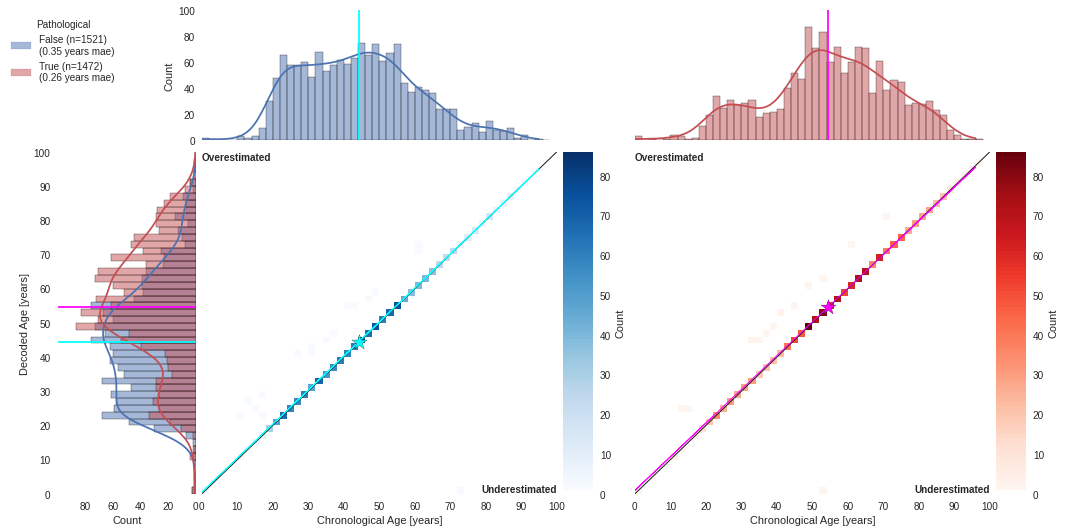

In [26]:
ax = plot_heatmaps(this_df,2,100,100)